In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import json
import matplotlib.animation as animation
%matplotlib inline


#### Loading an image using rasterio

In [2]:
from pathlib import Path

data_folder = Path().absolute().parent / "data"
print(data_folder)

/home/agarnier/Documents/code/propios/ens/MVA-rs-project/data


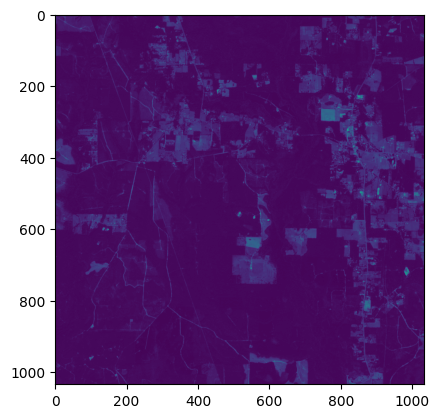

In [3]:
# Get path to raster

path_to_raster = data_folder / "sentinel-2/tx=37,ty=-332/20221010_B04.tif"
with rasterio.open(path_to_raster) as raster:
    
    # using the read function from rasterio you can read any bands contained in the raster
    # Every raster a single-channelled in this cases study, you can then read the content of the
    # raster as follows
    red = raster.read(1)/10_000
    plt.imshow(red)

#### Creating indices

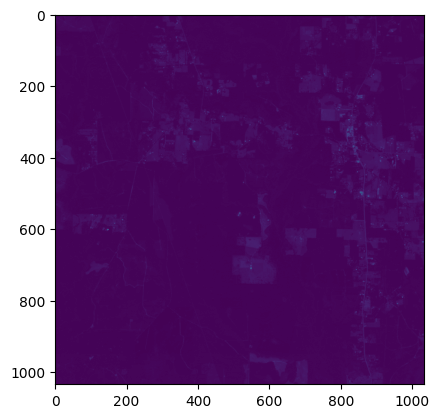

In [5]:
patch_folder = data_folder / "sentinel-2/tx=37,ty=-332"
patches = patch_folder.glob("*_B02.tif")
patches = list(patches)
patches.sort()


fig, ax = plt.subplots()
ims = []
for i, p in enumerate(patches):
    with rasterio.open(p) as r:
        red = r.read(1)/10_000
        im = ax.imshow(red, animated=True)
        if i == 0:
            ax.imshow(red)
        ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

# To save the animation, use e.g.
#
ani.save("B02.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.show()

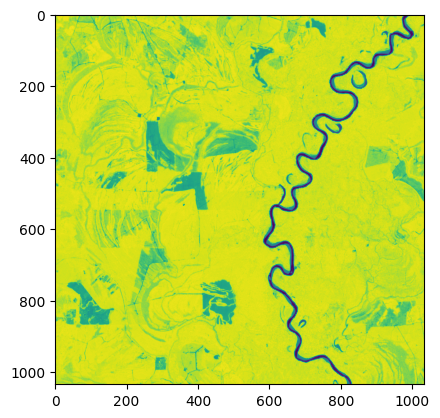

In [15]:
patch_folder = data_folder / "sentinel-2/tx=38,ty=-331"
patches1 = patch_folder.glob("*_B04.tif")
patches1 = list(patches1)
patches1.sort()
patches2 = patch_folder.glob("*_B08.tif")
patches2 = list(patches2)
patches2.sort()



def get_index(band1, band2):
    shape_1 = band1.shape
    shape_2 = band2.shape
    if np.sum(shape_1)>np.sum(shape_2):
        band2 = cv2.resize(band2, (shape_1[0], shape_1[1]))
    if np.sum(shape_2)>np.sum(shape_2):
        band1 = cv2.resize(band1, (shape_2[0], shape_2[1]))
    return (band1 - band2) / (band1 + band2)


fig, ax = plt.subplots()
ims = []
for i, (b04,b08) in enumerate(zip(patches1, patches2)):
    B04 = rasterio.open(b04).read(1)/10000
    B08 = rasterio.open(b08).read(1)/10000
    ndvi = get_index(B08, B04)
    im = ax.imshow(ndvi, animated=True)
    if i == 0:
        ax.imshow(ndvi)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True,
                                repeat_delay=1000)

# To save the animation, use e.g.
#
ani.save("NDVI.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.show()

A common processing step used in remote sensing is to work on indices rather than row data. This allows us to reduce the impact of the atmosphere and easily access meaningful features. Feel free to check https://giscrack.com/list-of-spectral-indices-for-sentinel-and-landsat/ to get more insights on the most common indices 

In [4]:
def get_index(band1, band2):
    shape_1 = band1.shape
    shape_2 = band2.shape
    if np.sum(shape_1)>np.sum(shape_2):
        band2 = cv2.resize(band2, (shape_1[0], shape_1[1]))
    if np.sum(shape_2)>np.sum(shape_2):
        band1 = cv2.resize(band1, (shape_2[0], shape_2[1]))
    return (band1 - band2) / (band1 + band2)


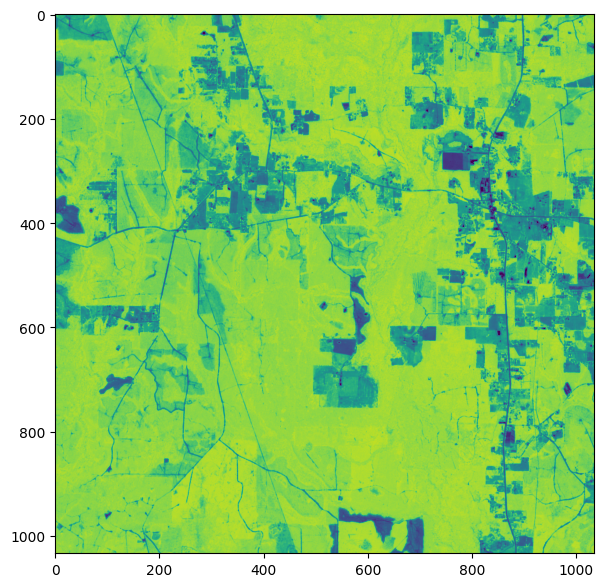

In [6]:
path_to_B04 = data_folder / "sentinel-2/tx=37,ty=-332/20221010_B04.tif"
path_to_B08 = data_folder / "sentinel-2/tx=37,ty=-332/20221010_B08.tif"
B04 = rasterio.open(path_to_B04).read(1)/10000
B08 = rasterio.open(path_to_B08).read(1)/10000
ndvi = get_index(B08, B04)
plt.figure(figsize=(7,7))
plt.imshow(ndvi, vmin=0, vmax=1)
plt.show()

#### Loading ground truth data

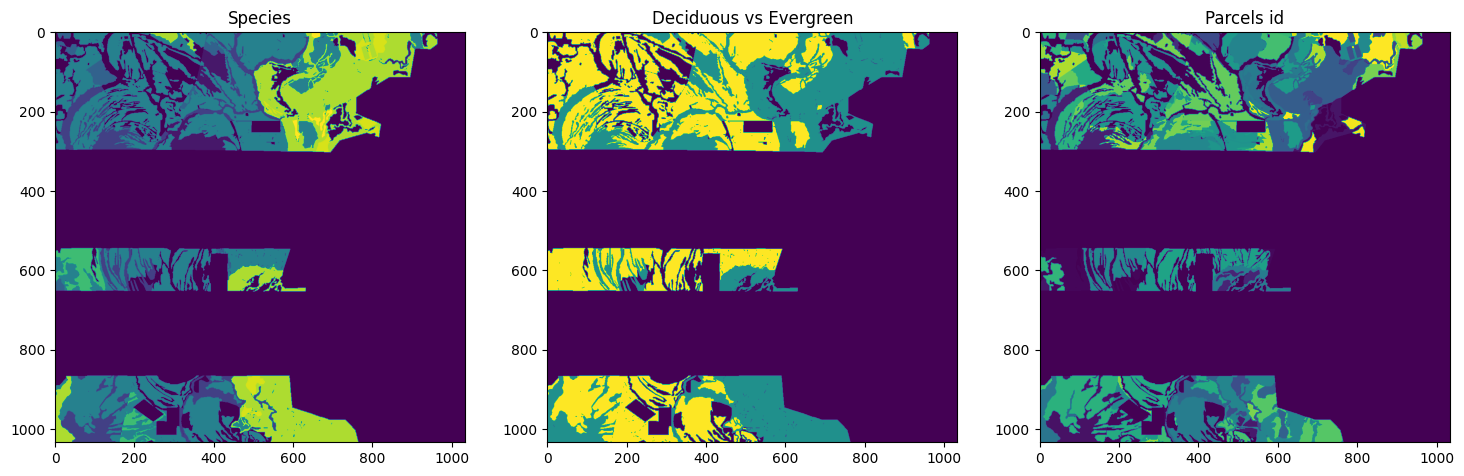

In [16]:
# Get path to raster
path_to_raster = data_folder / "ground_truth/tx=38,ty=-331.tif"
with rasterio.open(path_to_raster) as raster:

    species = raster.read(1)
    deciduous_evergreen = raster.read(2)
    parcel_id = raster.read(3)

# replacing nodata values
mask = (parcel_id==9999)
species[mask]=-1
deciduous_evergreen[mask]=-1
parcel_id[mask]=-1

fig, ax = plt.subplots(1,3, figsize=(18,7))
ax[0].imshow(species)
ax[0].set_title("Species")
ax[1].imshow(deciduous_evergreen)
ax[1].set_title("Deciduous vs Evergreen")
ax[2].imshow(parcel_id)
ax[2].set_title("Parcels id")
plt.show()

### Get relation between species id and names

In [8]:
species_indexing = json.load(open(data_folder / "ground_truth/species_indexing.json"))
deciduous_evergreen_indexing = json.load(open(data_folder / "ground_truth/deciduous_evergreen_indexing.json"))
print(species_indexing)
print()
print(deciduous_evergreen_indexing)

{'6': 'pinus taeda', '2': 'nyssa sylvatica', '0': 'cypress', '13': 'quercus nigra', '14': 'quercus pagoda', '3': 'pinus echinata', '4': 'pinus elliottii', '10': 'quercus laurifolia', '16': 'quercus rubra', '1': 'liquidambar', '5': 'pinus palustris', '15': 'quercus phellos', '8': 'quercus acutissima', '12': 'quercus michauxii', '17': 'quercus shumardii', '11': 'quercus lyrata', '18': 'triadica sebifera', '9': 'quercus falcata', '7': 'pseudotsuga menziesii'}

{'1': 'evergreen', '0': 'deciduous'}


### Usefull links

* Sentinel-2 bands : 
    * https://gisgeography.com/sentinel-2-bands-combinations/
* Sentinel-2 indices : 
    * https://giscrack.com/list-of-spectral-indices-for-sentinel-and-landsat/
* Tree Species Classification with Multi-Temporal Sentinel-2 Data : 
    * https://www.mdpi.com/2072-4292/10/11/1794
* Rasterio documentation : 
    * https://rasterio.readthedocs.io/en/latest/index.html

In [9]:
import os, glob
import datetime
from collections import defaultdict
import re

In [10]:
from skimage.transform import resize

In [11]:
def time_series(dir, ground_truth, agg_fn=np.mean):
  parcel_ids = rasterio.open(ground_truth).read(3)

  # store data in a dict (to be converted to pd.DataFrame later)
  data = defaultdict(lambda: defaultdict(lambda: np.nan))

  for f in glob.iglob(os.path.join(dir, '*_B*.tif')):
    img = rasterio.open(f).read(1)/10000

    # some bands have different sizes / pixel resolution (e.g. B11)
    for id in np.unique(parcel_ids):
      if parcel_ids.shape == img.shape:
        value = agg_fn(img[parcel_ids == id])
      else:
        value = agg_fn(resize(img, parcel_ids.shape)[parcel_ids == id])

      # extract band and date info from filename
      date, band = re.findall('[0-9]{8}_B[0-9]{2}', f)[0].split('_')
      date = datetime.datetime.strptime(date, '%Y%m%d').date()

      data[(band,id)][date] = value
      
  return data

In [12]:
# This command takes a while.
data = time_series(data_folder / "sentinel-2/tx=37,ty=-332", data_folder / "ground_truth/tx=37,ty=-332.tif")

In [13]:
pd.DataFrame(data, columns=pd.MultiIndex.from_tuples(data.keys(), names=["band", "parcel"])).sort_index()

band             B02                                                    \
parcel          153       156       168       205       248       249    
2018-12-15  0.017929  0.018409  0.013699  0.009802  0.010221  0.009847   
2019-01-24  0.006266  0.018747  0.012349  0.007213  0.007662  0.006662   
2019-01-29  0.010488  0.023346  0.017949  0.013339  0.013599  0.012407   
2019-02-13  0.012034  0.024276  0.018002  0.013630  0.013990  0.012094   
2019-03-05  0.018428  0.031598  0.027775  0.021312  0.022499  0.019547   
...              ...       ...       ...       ...       ...       ...   
2022-10-05  0.017523  0.020863  0.017841  0.054496  0.063095  0.047544   
2022-10-10  0.017813  0.021875  0.020786  0.057675  0.066235  0.050874   
2022-10-15  0.013638  0.019785  0.014713  0.050137  0.057623  0.042541   
2022-10-20  0.017715  0.021663  0.020119  0.054253  0.061375  0.047625   
2022-10-25  0.009200  0.012950  0.010603  0.044453  0.050790  0.037996   

band                                                ...       B08            \
parcel          255       256       258       307   ...      1988      2017   
2018-12-15  0.023510  0.015456  0.015975  0.012858  ...  0.206527  0.221542   
2019-01-24  0.023426  0.013972  0.015018  0.009924  ...  0.205221  0.222671   
2019-01-29  0.028961  0.019284  0.020300  0.015972  ...  0.214368  0.233638   
2019-02-13  0.028567  0.019696  0.020045  0.016057  ...  0.204185  0.223543   
2019-03-05  0.002544  0.027546  0.028224  0.024256  ...  0.216041  0.228288   
...              ...       ...       ...       ...  ...       ...       ...   
2022-10-05  0.021156  0.022775  0.018794  0.019547  ...  0.257124  0.278392   
2022-10-10  0.024066  0.021006  0.021861  0.022367  ...  0.256842  0.275456   
2022-10-15  0.017957  0.014950  0.015373  0.015992  ...  0.246871  0.256070   
2022-10-20  0.022946  0.020170  0.020976  0.021302  ...  0.257366  0.273135   
2022-10-25  0.014641  0.011108  0.011760  0.011781  ...  0.256776  0.274060   

band                                                                    \
parcel          2018      2110      2111      2176      2283      2372   
2018-12-15  0.207494  0.242236  0.246890  0.154712  0.149328  0.210505   
2019-01-24  0.211385  0.220951  0.210747  0.180927  0.167488  0.214158   
2019-01-29  0.209795  0.207506  0.219980  0.193964  0.181830  0.232881   
2019-02-13  0.217160  0.229381  0.212778  0.190931  0.184695  0.224795   
2019-03-05  0.208585  0.000000  0.046386  0.205525  0.196048  0.238613   
...              ...       ...       ...       ...       ...       ...   
2022-10-05  0.229582  0.254080  0.268142  0.235562  0.250325  0.259035   
2022-10-10  0.226860  0.244735  0.264063  0.254527  0.248269  0.255964   
2022-10-15  0.215729  0.237693  0.252762  0.244852  0.237314  0.240926   
2022-10-20  0.221923  0.237539  0.261743  0.255155  0.242227  0.232785   
2022-10-25  0.222324  0.239622  0.262296  0.254150  0.243050  0.229836   

band                            
parcel          2401      9999  
2018-12-15  0.195377  0.208976  
2019-01-24  0.208736  0.216171  
2019-01-29  0.211247  0.221916  
2019-02-13  0.213679  0.220863  
2019-03-05  0.215872  0.211295  
...              ...       ...  
2022-10-05  0.257345  0.259398  
2022-10-10  0.252552  0.255077  
2022-10-15  0.234998  0.244396  
2022-10-20  0.236406  0.249288  
2022-10-25  0.229711  0.248650  

[73 rows x 430 columns]

To deal with later: some parcels may stretch over multiple tiffs:

In [14]:
all_ids = []
gt_folder = data_folder / "ground_truth"
for gt in gt_folder.glob("*.tif"):
  parcel_id = rasterio.open(gt).read(3)
  all_ids.extend(np.unique(parcel_id).tolist())

In [15]:
len(all_ids)

548

In [16]:
len(set(all_ids))

485